In [18]:
from tensorflow.keras.applications import EfficientNetB0
import os
import numpy as Numpy
import pandas as Pandas
import tensorflow as TensorFlow
import matplotlib.pyplot as Pyplot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import load_model
from keras.models import Model
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
from natsort import natsorted
from matplotlib import pyplot as plt

**Indexes for Image Classes:**

0. Fabric
1. Foliage
2. Glass
3. Leather
4. Metal
5. Paper
6. Plastic
7. Stone
8. Water
9. Wood

In [7]:
classes = ["Foliage", "Glass", "Leather", "Metal",
"Paper", "Plastic", "Stone", "Maize", "Water",
"Wood"]

train_directory = "../Material-Recognition-Data/augmented_images"
# test_directory = "drive/MyDrive//CX4041-Group-Project/Preprocessed_Test_Images/test"

In [31]:
# Define the width and height of the input images.
width = 150
height = 150
batch_size = 64

In [24]:
# Prepare the training and test plant images datasets.
material_training_dataset = image_dataset_from_directory(
    # Directory path for all the images.
    train_directory,

    # Generate labels automatically based on the directory structure, one class per folder of plant type.
    labels = 'inferred',

    # Set to type 'int' as we are using sparse categorical cross entropy loss, where each sample belongs to exactly one class.
    label_mode = 'int',

    # If class names must be explicitly stated.
    class_names = None,

    # Colour format to read in the images.
    color_mode = 'rgb',

    # Dimensions of the input images.
    image_size = (width, height),

    # Batch size.
    batch_size = batch_size,

    # Randomly shuffle the data.
    shuffle = True,

    # Set the random seed to the same fixed value for both to ensure mutual exclusion of samples for training and validation.
    seed = 0,

    # Fraction of data in the original dataset to put aside for validation.
    validation_split = 0.1,

    # Determines which portion of the dataset is returned, which in this case is the remaining 70% not used for validation.
    subset = 'training'
)
print(type(material_training_dataset), '\n')

material_validation_dataset = TensorFlow.keras.preprocessing.image_dataset_from_directory(
   train_directory,
    labels = 'inferred',
    label_mode = 'int',
    class_names = None,
    color_mode = 'rgb',
    image_size = (width, height),
    batch_size = batch_size,
    shuffle = True,
    seed = 0,
    validation_split = 0.1,
    subset = 'validation'
)
print(type(material_validation_dataset))

Found 10000 files belonging to 10 classes.
Using 9000 files for training.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 

Found 10000 files belonging to 10 classes.
Using 1000 files for validation.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


Number of material type:  10


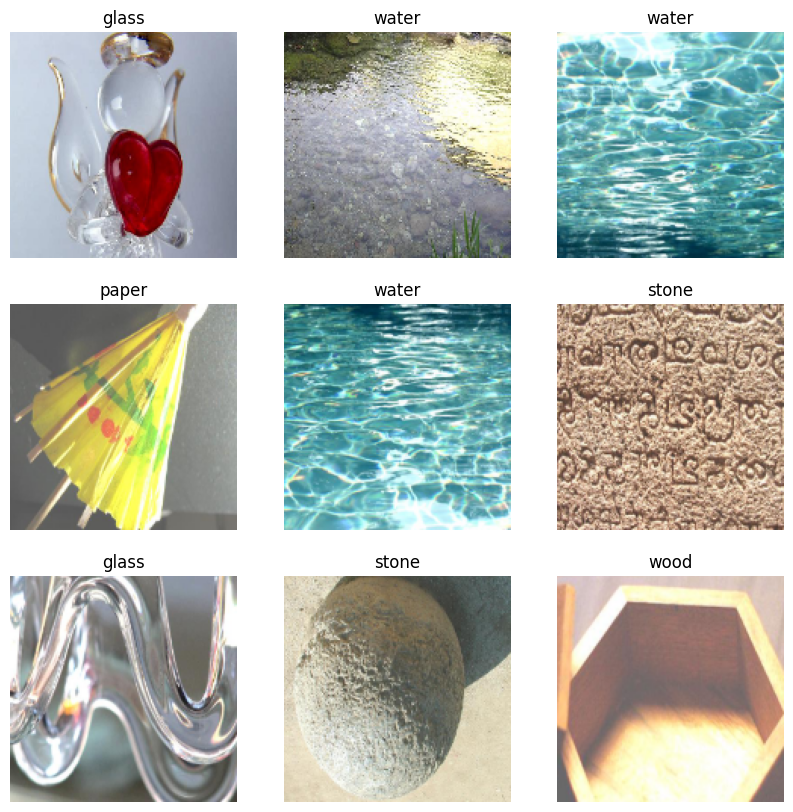

In [30]:
class_names = material_validation_dataset.class_names
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for images, labels in material_training_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


material_type = os.listdir(train_directory)
print("Number of material type: ", len(material_type))

In [49]:

from keras.applications import EfficientNetB2


def build_model(num_classes):
    # Define an instance of the EfficientNet model that we are going to adapt.
    # Original weights will be downloaded on the first run and stored locally.
    model = EfficientNetB2(

    # Whether to include the last 3 fully connected (dense) layers of the EfficientNet network.
    # Set to false here because we are using a larger image size than ImageNet.
    include_top = False,

    # Reuse the weights from the pretraining of the 'imagenet' model.
    weights = 'imagenet',

    # Keras tensor to use as an input image to the model.
    input_tensor = None,

    # Pooling mode for feature extraction.
    pooling = 'avg'
    )

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    # Note: The convolutional layers act as feature extractors while the fully connected (dense/top) layers
    # serve to interpret the extracted features from the images to classify them.

    inputs = layers.Input(shape=(height, width, 3))

    # Rebuild top
    x = layers.BatchNormalization()

    # Drop out
    x = layers.Dropout(0.5, name = 'drop2')(x)
    x = layers.Dense(100, activation = "relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.5, name = 'drop1')(x)
    x = layers.Dense(50, activation = "relu")(x)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = TensorFlow.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = optimizer=TensorFlow.keras.optimizers.Nadam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]

    )

    return model

In [50]:
def input_preprocess(image, label):
    label = TensorFlow.one_hot(label, 12)
    return image, label

In [51]:
train_ds = material_training_dataset.map(
    input_preprocess, num_parallel_calls=TensorFlow.data.experimental.AUTOTUNE
)

strategy = TensorFlow.distribute.MirroredStrategy()

with strategy.scope():
    model = build_model(num_classes=num_classes)

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
31790344/31790344 [==============================] - 3s 0us/step


ValueError: Input 0 of layer "avg_pool" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1408)